<h1>Table of Contents</h1>
<ul>
  <li><a href="#section1">1. Import Necessary Libraries</a></li>
  <li><a href="#section2">2. Load Data</a></li>
  <li><a href="#section3">3. Data Preprocessing</a></li>
  <li><a href="#section4">4. Define Model Components</a></li>
  <li><a href="#section5">5. Build and Configure Model</a></li>
  <li><a href="#section6">6. Prepare Data Sample</a></li>
  <li><a href="#section7">7. Model Fitting</a></li>
  <li><a href="#section8">8. Visualization and Analysis</a>
    <ul>
      <li><a href="#section8_1">8.1 Model Fit Diagnostics</a></li>
    </ul>
  </li>
</ul>


<a id="section1"></a>
# 1. Import Necessary Libraries

In [3]:
import os
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'  # Disable file validation for smoother execution
os.environ['PYTHONDEVMODE'] = 'off'                  # Turn off Python development mode
import pandas as pd                                  # For data manipulation and analysis
import pyddm                                         # For building and fitting diffusion decision models
from pyddm import Sample                             # To create sample objects for model fitting
import numpy as np                                   # For numerical operations
import pyddm.plot                                    # For plotting model diagnostics (imported first as required)
import matplotlib                                    # For visualization
matplotlib.use('TkAgg')                              # Set matplotlib backend to TkAgg for interactive plotting
import matplotlib.pyplot as plt                      # For creating plots
from IPython.display import Image                    # For displaying images in the notebook

<a id="section2"></a>
# 2. Load Data

In [5]:
# Load and preprocess the data
file_path = '/Users/wangyue/Desktop/data/incon_6Frame/HDDM_InconStim_6Frame.csv'
data_F = pd.read_csv(file_path)

<a id="section3"></a>
# 3. Data Preprocessing

In [7]:
# Select relevant columns for modeling and create a copy to avoid modifying the original data
data_for_model = data_F[['subj_idx', 'trial', 'rt', 'response', 'HSF_emo', 'task']].copy()
# Preserve original categorical columns for reference
data_for_model['task_original'] = data_for_model['task']        # Store original 'task' values
data_for_model['HSF_emo_original'] = data_for_model['HSF_emo']  # Store original 'HSF_emo' values
# Convert categorical variables 'task' and 'HSF_emo' into dummy variables for modeling
data_for_model = pd.get_dummies(data_for_model, columns=['task', 'HSF_emo'], prefix=['task', 'HSF_emo'])

In [8]:
# Display summary statistics of reaction times to understand their distribution
print("Summary statistics of reaction times:")
print(data_for_model['rt'].describe())  # Shows that reaction times are mostly around 2 seconds, with outliers up to ~68 seconds

Summary statistics of reaction times:
count    9750.000000
mean        0.828259
std         0.467399
min         0.010953
25%         0.584762
50%         0.714717
75%         0.909147
max         9.255789
Name: rt, dtype: float64


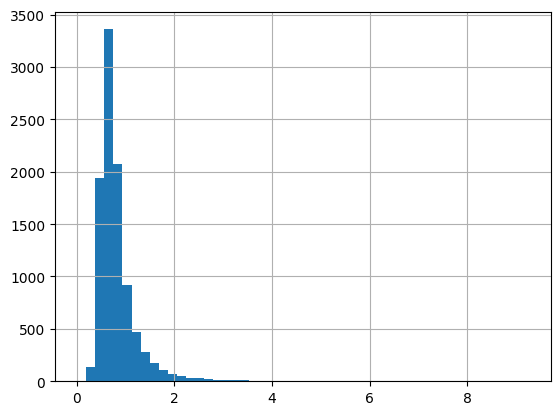

In [9]:
# Visualize the distribution of reaction times with a histogram
%matplotlib inline
data_for_model['rt'].hist(bins=50)
plt.show()

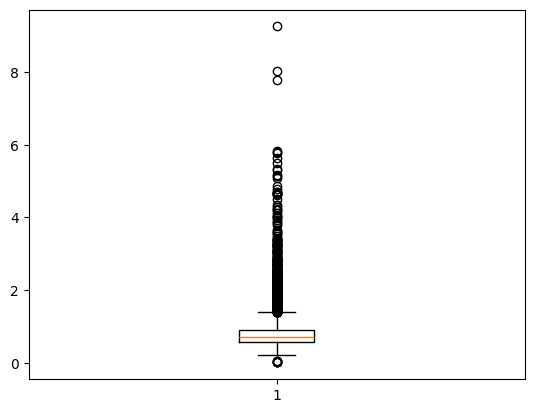

In [10]:
# Use a boxplot to visually confirm the presence of outliers in reaction times
plt.boxplot(data_for_model['rt'])
plt.show()

In [11]:
# Filter out extreme reaction times (rt >= 5 seconds) to improve model fitting
rt_threshold = 5.0
data_for_model_filtered = data_for_model[data_for_model['rt'] < rt_threshold]
print("Summary statistics of filtered reaction times:", data_for_model_filtered['rt'].describe())

Summary statistics of filtered reaction times: count    9737.000000
mean        0.821185
std         0.423111
min         0.010953
25%         0.584603
50%         0.714277
75%         0.908068
max         4.860230
Name: rt, dtype: float64


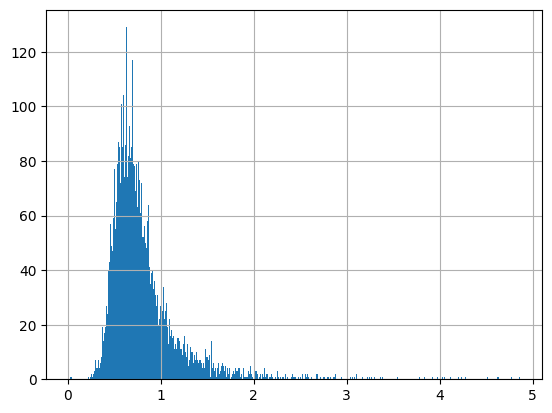

In [12]:
# Visualize the filtered reaction time distribution with a detailed histogram
%matplotlib inline
data_for_model_filtered['rt'].hist(bins=1000)
plt.show()

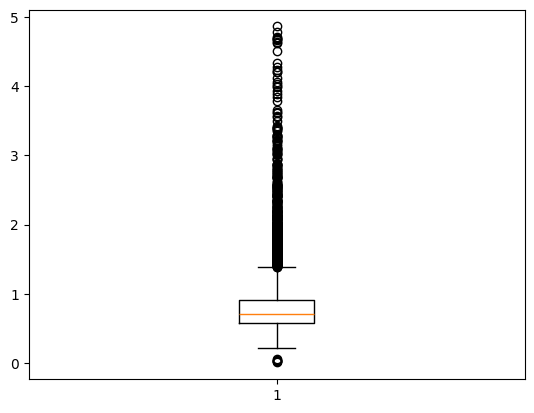

In [13]:
# Use a boxplot to check for remaining outliers in the filtered data
plt.boxplot(data_for_model_filtered['rt'])
plt.show()

<a id="section4"></a>
# 4. Define Model Components

In [15]:
# Define drift function for Model 4, dependent on HSF_emo conditions
def drift_function(HSF_emo_1, HSF_emo_2, drift_emo1, drift_emo2, leak, t, x):
    """
    Drift rate function for Model 4, dependent on HSF_emo conditions.
    
    Parameters:
    - HSF_emo_1, HSF_emo_2: Dummy variables representing HSF_emo levels (conditions).
    - drift_emo1: Drift parameter for HSF_emo_1 condition.
    - drift_emo2: Drift parameter for HSF_emo_2 condition.
    - leak: Leak parameter for the integrator.
    - t: Time (not used directly but included for consistency with pyDDM).
    - x: Accumulated evidence.
    
    Returns:
    - Adjusted drift rate incorporating HSF_emo conditions and leaky integration.
    """
    base_drift = drift_emo1 * HSF_emo_1 + drift_emo2 * HSF_emo_2  # Compute base drift based on HSF_emo conditions
    drift = base_drift - leak * x  # Apply leaky integrator to adjust drift
    if np.any(np.isnan(drift)) or np.any(np.isinf(drift)):  # Check for numerical errors
        print(f"Drift function error: {drift}")
    return drift * np.ones_like(x)  # Ensure output shape matches input x for compatibility with pyDDM

In [16]:
# Define bound function for Model 4, dependent on task conditions
def bound_function(task_1, task_2, task_3, threshold1, threshold2, threshold3, invtau, t):
    """
    Bound function for Model 4, with task-dependent thresholds and exponential decay.
    
    Parameters:
    - task_1, task_2, task_3: Dummy variables representing task categories (0 or 1).
    - threshold1, threshold2, threshold3: Initial threshold parameters for each task category.
    - invtau: Threshold decay rate.
    - t: Time.
    
    Returns:
    - Task-dependent decision boundary that decays over time.
    """
    # Calculate base threshold by selecting the appropriate threshold parameter based on task
    base_bound = threshold1 * task_1 + threshold2 * task_2 + threshold3 * task_3
    
    # Apply time-dependent exponential decay to the threshold
    bound = base_bound * np.exp(-t * invtau)
    
    # Check for numerical stability
    if np.any(np.isnan(bound)) or np.any(np.isinf(bound)):
        print(f"Bound function error: {bound}")
    return bound

<a id="section5"></a>
# 5. Build and Configure Model

In [18]:
# Build and configure Model 4 with HSF_emo-dependent drift and task-dependent bound
model_4 = pyddm.gddm(
    drift=drift_function,  # Use the custom HSF_emo-dependent drift function
    noise=1.0,             # Fixed noise level for the diffusion process
    bound=bound_function,  # Use the custom task-dependent bound function with decay
    nondecision="nt",      # Non-decision time parameter
    starting_position="x0",# Starting position parameter (fixed across conditions)
    parameters={
        "drift_emo1": (0, 4), "drift_emo2": (-3, 0),  # Ranges for HSF_emo drift parameters
        "threshold1": (0.5, 1.2), "threshold2": (0.5, 1.2), "threshold3": (0.5, 1.2),  # Ranges for task-specific thresholds
        "x0": (-0.25, 0.25),       # Range for starting position of evidence
        "nt": (0.05, 1),           # Range for non-decision time
        "leak": (0, 0.03),         # Range for leak parameter in the integrator
        "invtau": (0.1, 5)         # Range for decay rate in the bound function
    },
    conditions=["task_1", "task_2", "task_3", "HSF_emo_1", "HSF_emo_2"],  # Specify both task and HSF_emo dummy variables as conditions
    T_dur=5.0  # Simulation duration in seconds
)

<a id="section6"></a>
# 6. Prepare Data Sample

In [20]:
# Convert the filtered DataFrame into a pyDDM Sample object for model fitting
data_sample_filtered = Sample.from_pandas_dataframe(data_for_model_filtered, rt_column_name='rt', choice_column_name='response')

<a id="section7"></a>
# 7. Model Fitting

In [22]:
# Attempt to fit Model 4 to the filtered data sample using BIC loss
try:
    model_4.fit(data_sample_filtered, lossfunction=pyddm.LossBIC, verbose=True)
except Exception as e:
    print(f"Error during model fitting: {e}")  # Report any fitting errors for debugging
    print(f"Current model parameters: {model_4.parameters}")  # Display parameters if fitting fails

Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.7537936790068689, minval=0, maxval=4), drift_emo2=Fitted(-2.10866585688712, minval=-3, maxval=0), leak=Fitted(0.025339822535264275, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(0.8625870809443051, minval=0.5, maxval=1.2), threshold2=Fitted(0.5335643094459792, minval=0.5, maxval=1.2), threshold3=Fitted(1.1025461601415334, minval=0.5, maxval=1.2), invtau=Fitted(1.079346810770878, minval=0.1, maxval=5)), IC=ICPointRatio(x0=Fitted(-0.23416842544721408, minval=-0.25, maxval=0.25)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.11410091191712857, minval=0.05, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=52867.539758258594
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.7754462437279379, minval=0, maxval=4), drift_emo2=Fitted(-2.1877419667862927, minval=-3, maxval=0), leak=Fitted(0.019629674490586946, minval=0, m

differential_evolution step 1: f(x)= 17831.092118410874


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.0189805713367894, minval=0, maxval=4), drift_emo2=Fitted(-1.936955465046276, minval=-3, maxval=0), leak=Fitted(0.023555242237073084, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(1.0122359187727672, minval=0.5, maxval=1.2), threshold2=Fitted(0.9115673311734082, minval=0.5, maxval=1.2), threshold3=Fitted(0.7757494274656752, minval=0.5, maxval=1.2), invtau=Fitted(2.741797491318413, minval=0.1, maxval=5)), IC=ICPointRatio(x0=Fitted(-0.09458733585839019, minval=-0.25, maxval=0.25)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.2836698644281799, minval=0.05, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=44615.140913497155
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.14814204846569812, minval=0, maxval=4), drift_emo2=Fitted(-0.4745921709487373, minval=-3, maxval=0), leak=Fitted(0.016489364144622095, minval=0, 

differential_evolution step 2: f(x)= 17145.200964411797


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.6112390878634388, minval=0, maxval=4), drift_emo2=Fitted(-2.163463471924785, minval=-3, maxval=0), leak=Fitted(0.022113884980132958, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(0.8103365673334652, minval=0.5, maxval=1.2), threshold2=Fitted(1.0038803649422192, minval=0.5, maxval=1.2), threshold3=Fitted(0.9318146046209199, minval=0.5, maxval=1.2), invtau=Fitted(2.8127071360856153, minval=0.1, maxval=5)), IC=ICPointRatio(x0=Fitted(-0.19968973094204778, minval=-0.25, maxval=0.25)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.21726813080015944, minval=0.05, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=59878.124243610975
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(2.078546680119588, minval=0, maxval=4), drift_emo2=Fitted(-1.3600547151779123, minval=-3, maxval=0), leak=Fitted(0.010397274154859497, minval=0, 

differential_evolution step 3: f(x)= 17145.200964411797


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(2.0428694014744346, minval=0, maxval=4), drift_emo2=Fitted(-0.27218006168841624, minval=-3, maxval=0), leak=Fitted(0.010501870331041708, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(0.6996415937772922, minval=0.5, maxval=1.2), threshold2=Fitted(0.9451122474347415, minval=0.5, maxval=1.2), threshold3=Fitted(0.550222753436451, minval=0.5, maxval=1.2), invtau=Fitted(0.45857685294602213, minval=0.1, maxval=5)), IC=ICPointRatio(x0=Fitted(-0.2094760362323419, minval=-0.25, maxval=0.25)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3173431127073487, minval=0.05, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=20723.430062024214
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.3206137083500016, minval=0, maxval=4), drift_emo2=Fitted(-0.4745921709487373, minval=-3, maxval=0), leak=Fitted(0.011044123074461797, minval=0,

differential_evolution step 4: f(x)= 15236.29781581999


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(2.0989461129528704, minval=0, maxval=4), drift_emo2=Fitted(-0.7833959272005946, minval=-3, maxval=0), leak=Fitted(0.007939917272337279, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(0.7986649300644385, minval=0.5, maxval=1.2), threshold2=Fitted(0.8815548418573201, minval=0.5, maxval=1.2), threshold3=Fitted(0.9852057641951432, minval=0.5, maxval=1.2), invtau=Fitted(0.33859267651634894, minval=0.1, maxval=5)), IC=ICPointRatio(x0=Fitted(-0.028388261596299952, minval=-0.25, maxval=0.25)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.33207022381969953, minval=0.05, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=16832.09611295005
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.3206137083500016, minval=0, maxval=4), drift_emo2=Fitted(-0.4745921709487373, minval=-3, maxval=0), leak=Fitted(0.013629951772793029, minval=

differential_evolution step 5: f(x)= 15236.29781581999


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.5072624170324824, minval=0, maxval=4), drift_emo2=Fitted(-0.7833959272005946, minval=-3, maxval=0), leak=Fitted(0.016244438214451297, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(0.7545869638413834, minval=0.5, maxval=1.2), threshold2=Fitted(0.7627710199027206, minval=0.5, maxval=1.2), threshold3=Fitted(0.8025729843454597, minval=0.5, maxval=1.2), invtau=Fitted(0.33859267651634894, minval=0.1, maxval=5)), IC=ICPointRatio(x0=Fitted(-0.009811890133882867, minval=-0.25, maxval=0.25)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.4360611011777347, minval=0.05, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=20184.931547871925
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(2.561508398821487, minval=0, maxval=4), drift_emo2=Fitted(-0.4745921709487373, minval=-3, maxval=0), leak=Fitted(0.0014157849513193894, minval=

differential_evolution step 6: f(x)= 14971.217195347626


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.5660511607086505, minval=0, maxval=4), drift_emo2=Fitted(-0.45278626419467205, minval=-3, maxval=0), leak=Fitted(0.0077074936708209476, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(0.6447643687812585, minval=0.5, maxval=1.2), threshold2=Fitted(0.6767357761835805, minval=0.5, maxval=1.2), threshold3=Fitted(1.1188599575065634, minval=0.5, maxval=1.2), invtau=Fitted(0.5719193197598338, minval=0.1, maxval=5)), IC=ICPointRatio(x0=Fitted(-0.008104492468570229, minval=-0.25, maxval=0.25)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.2548092619332669, minval=0.05, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=21141.771576283616
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.1366031883782464, minval=0, maxval=4), drift_emo2=Fitted(-0.059753312684313276, minval=-3, maxval=0), leak=Fitted(0.002918686117084089, minv

differential_evolution step 7: f(x)= 14971.217195347626


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.0995888905110425, minval=0, maxval=4), drift_emo2=Fitted(-0.9233270591505964, minval=-3, maxval=0), leak=Fitted(0.011044123074461797, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(1.1557407002112772, minval=0.5, maxval=1.2), threshold2=Fitted(1.0362008623326098, minval=0.5, maxval=1.2), threshold3=Fitted(0.727826754691683, minval=0.5, maxval=1.2), invtau=Fitted(0.5386094017441176, minval=0.1, maxval=5)), IC=ICPointRatio(x0=Fitted(0.14936012551680555, minval=-0.25, maxval=0.25)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.34856813429916517, minval=0.05, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=17735.69308148443
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.1366031883782464, minval=0, maxval=4), drift_emo2=Fitted(-0.42586113545601334, minval=-3, maxval=0), leak=Fitted(0.0019513372649914863, minval=0,

differential_evolution step 8: f(x)= 14640.460934636018


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.737182369519802, minval=0, maxval=4), drift_emo2=Fitted(-0.24480570308361904, minval=-3, maxval=0), leak=Fitted(0.010684617114646498, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(0.8281220118317916, minval=0.5, maxval=1.2), threshold2=Fitted(1.0362008623326098, minval=0.5, maxval=1.2), threshold3=Fitted(1.1383737888826375, minval=0.5, maxval=1.2), invtau=Fitted(0.2932093089993564, minval=0.1, maxval=5)), IC=ICPointRatio(x0=Fitted(-0.12277788850392099, minval=-0.25, maxval=0.25)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.26397927222052114, minval=0.05, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=16275.737824911897
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.2525297154899198, minval=0, maxval=4), drift_emo2=Fitted(-0.42586113545601334, minval=-3, maxval=0), leak=Fitted(0.008775360603331428, minval=

differential_evolution step 9: f(x)= 14640.460934636018


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.2986944718558577, minval=0, maxval=4), drift_emo2=Fitted(-0.3116365895830753, minval=-3, maxval=0), leak=Fitted(0.0009134193671842521, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(1.091733333125515, minval=0.5, maxval=1.2), threshold2=Fitted(0.8116317769844966, minval=0.5, maxval=1.2), threshold3=Fitted(0.8920817389971006, minval=0.5, maxval=1.2), invtau=Fitted(0.49262993693958235, minval=0.1, maxval=5)), IC=ICPointRatio(x0=Fitted(-0.10023280596485401, minval=-0.25, maxval=0.25)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.13467755477276777, minval=0.05, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=20058.21229400985
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.737182369519802, minval=0, maxval=4), drift_emo2=Fitted(-0.695119978914355, minval=-3, maxval=0), leak=Fitted(0.010684617114646498, minval=0, 

differential_evolution step 10: f(x)= 14640.460934636018


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.737182369519802, minval=0, maxval=4), drift_emo2=Fitted(-0.3419776389355249, minval=-3, maxval=0), leak=Fitted(0.007006291861787925, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(0.8281220118317916, minval=0.5, maxval=1.2), threshold2=Fitted(1.0553404557580335, minval=0.5, maxval=1.2), threshold3=Fitted(0.8825729747675752, minval=0.5, maxval=1.2), invtau=Fitted(0.711511662704956, minval=0.1, maxval=5)), IC=ICPointRatio(x0=Fitted(0.0721193725674108, minval=-0.25, maxval=0.25)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.26397927222052114, minval=0.05, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=17881.155930697492
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.23967471676709806, minval=0, maxval=4), drift_emo2=Fitted(-0.46184696436777983, minval=-3, maxval=0), leak=Fitted(0.008643384415281511, minval=0, 

differential_evolution step 11: f(x)= 14640.460934636018


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.5978554875112918, minval=0, maxval=4), drift_emo2=Fitted(-0.36126942323209343, minval=-3, maxval=0), leak=Fitted(0.004788382257637669, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(0.8281220118317916, minval=0.5, maxval=1.2), threshold2=Fitted(0.8573484261010471, minval=0.5, maxval=1.2), threshold3=Fitted(0.8468608145120726, minval=0.5, maxval=1.2), invtau=Fitted(0.2932093089993564, minval=0.1, maxval=5)), IC=ICPointRatio(x0=Fitted(-0.19032928640257402, minval=-0.25, maxval=0.25)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.31044470503834565, minval=0.05, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15354.755441657308
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.5036539180055744, minval=0, maxval=4), drift_emo2=Fitted(-0.5548020898077624, minval=-3, maxval=0), leak=Fitted(0.004372592160958883, minval=

differential_evolution step 12: f(x)= 14555.088649218947


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.0281754739889792, minval=0, maxval=4), drift_emo2=Fitted(-0.7266342174872622, minval=-3, maxval=0), leak=Fitted(0.0062306385125126835, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(0.7164059773009963, minval=0.5, maxval=1.2), threshold2=Fitted(0.7467061018593351, minval=0.5, maxval=1.2), threshold3=Fitted(0.8786552750621386, minval=0.5, maxval=1.2), invtau=Fitted(0.2902092698779706, minval=0.1, maxval=5)), IC=ICPointRatio(x0=Fitted(-0.04257860534501973, minval=-0.25, maxval=0.25)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.33705460960891453, minval=0.05, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15243.431262405053
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.5276417210235307, minval=0, maxval=4), drift_emo2=Fitted(-0.5894944124535342, minval=-3, maxval=0), leak=Fitted(0.014313637417554514, minval=

differential_evolution step 13: f(x)= 14555.088649218947


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.8324887557342171, minval=0, maxval=4), drift_emo2=Fitted(-1.0554536072259229, minval=-3, maxval=0), leak=Fitted(0.0030712488531244274, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(0.7641445147176134, minval=0.5, maxval=1.2), threshold2=Fitted(0.6370036634927208, minval=0.5, maxval=1.2), threshold3=Fitted(0.5769189290403054, minval=0.5, maxval=1.2), invtau=Fitted(4.355066310922485, minval=0.1, maxval=5)), IC=ICPointRatio(x0=Fitted(0.13405929859700216, minval=-0.25, maxval=0.25)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.39436001384037145, minval=0.05, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=55896.36817217807
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.755240153832938, minval=0, maxval=4), drift_emo2=Fitted(-2.0694103074121655, minval=-3, maxval=0), leak=Fitted(0.022277419368873057, minval=0, m

differential_evolution step 14: f(x)= 14555.088649218947


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.2169068074018172, minval=0, maxval=4), drift_emo2=Fitted(-0.7266342174872622, minval=-3, maxval=0), leak=Fitted(0.0062306385125126835, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(0.7476973392066939, minval=0.5, maxval=1.2), threshold2=Fitted(0.7467061018593351, minval=0.5, maxval=1.2), threshold3=Fitted(0.6513296264543418, minval=0.5, maxval=1.2), invtau=Fitted(0.35421472331765846, minval=0.1, maxval=5)), IC=ICPointRatio(x0=Fitted(0.04405993970857042, minval=-0.25, maxval=0.25)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.33705460960891453, minval=0.05, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15910.241610176292
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.0542270188786016, minval=0, maxval=4), drift_emo2=Fitted(-0.1346617630557303, minval=-3, maxval=0), leak=Fitted(0.004372592160958883, minval=

differential_evolution step 15: f(x)= 14428.060484665399


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.0281754739889792, minval=0, maxval=4), drift_emo2=Fitted(-0.3839899494550849, minval=-3, maxval=0), leak=Fitted(0.0062306385125126835, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(0.7164059773009963, minval=0.5, maxval=1.2), threshold2=Fitted(0.8620768051130896, minval=0.5, maxval=1.2), threshold3=Fitted(0.7640538237681592, minval=0.5, maxval=1.2), invtau=Fitted(0.15462397159543606, minval=0.1, maxval=5)), IC=ICPointRatio(x0=Fitted(-0.07384345626303257, minval=-0.25, maxval=0.25)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.33961682967363893, minval=0.05, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=15052.62274214526
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.04527366405892, minval=0, maxval=4), drift_emo2=Fitted(-0.10644261556788637, minval=-3, maxval=0), leak=Fitted(0.004372592160958883, minval=0

differential_evolution step 16: f(x)= 14428.060484665399


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.2407493541124481, minval=0, maxval=4), drift_emo2=Fitted(-0.2595020140112365, minval=-3, maxval=0), leak=Fitted(0.00986271802576236, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(0.822296437164291, minval=0.5, maxval=1.2), threshold2=Fitted(0.8770246447163375, minval=0.5, maxval=1.2), threshold3=Fitted(0.850377686323484, minval=0.5, maxval=1.2), invtau=Fitted(0.15462397159543606, minval=0.1, maxval=5)), IC=ICPointRatio(x0=Fitted(-0.012090371473306133, minval=-0.25, maxval=0.25)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.2988869613995039, minval=0.05, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14750.80584590868
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.0884516403306015, minval=0, maxval=4), drift_emo2=Fitted(-0.5741342003897892, minval=-3, maxval=0), leak=Fitted(0.004372592160958883, minval=0, m

differential_evolution step 17: f(x)= 14428.060484665399


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.2407493541124481, minval=0, maxval=4), drift_emo2=Fitted(-0.17476044835143711, minval=-3, maxval=0), leak=Fitted(0.00986271802576236, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(0.7810392950855432, minval=0.5, maxval=1.2), threshold2=Fitted(0.7400349485528452, minval=0.5, maxval=1.2), threshold3=Fitted(0.7748763678657475, minval=0.5, maxval=1.2), invtau=Fitted(2.5227631286908276, minval=0.1, maxval=5)), IC=ICPointRatio(x0=Fitted(-0.01687397440584551, minval=-0.25, maxval=0.25)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.31227577202145473, minval=0.05, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=39251.625787600424
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.4362495751716844, minval=0, maxval=4), drift_emo2=Fitted(-0.5741342003897892, minval=-3, maxval=0), leak=Fitted(0.014029224720225874, minval=0

differential_evolution step 18: f(x)= 14428.060484665399


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.111163334361092, minval=0, maxval=4), drift_emo2=Fitted(-0.2003946550487039, minval=-3, maxval=0), leak=Fitted(0.02081826175729834, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(0.8864818424152969, minval=0.5, maxval=1.2), threshold2=Fitted(0.7861569757113337, minval=0.5, maxval=1.2), threshold3=Fitted(0.9219105091462549, minval=0.5, maxval=1.2), invtau=Fitted(0.4164578560372574, minval=0.1, maxval=5)), IC=ICPointRatio(x0=Fitted(0.05078652205201106, minval=-0.25, maxval=0.25)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3332699993057736, minval=0.05, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14822.947923489402
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.9920910368256144, minval=0, maxval=4), drift_emo2=Fitted(-0.31997082187499215, minval=-3, maxval=0), leak=Fitted(0.01174161165025624, minval=0, ma

differential_evolution step 19: f(x)= 14335.826352318416


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.2407493541124481, minval=0, maxval=4), drift_emo2=Fitted(-0.2595020140112365, minval=-3, maxval=0), leak=Fitted(0.0023286403051729493, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(0.822296437164291, minval=0.5, maxval=1.2), threshold2=Fitted(0.824965549416127, minval=0.5, maxval=1.2), threshold3=Fitted(0.8207107934552429, minval=0.5, maxval=1.2), invtau=Fitted(0.15462397159543606, minval=0.1, maxval=5)), IC=ICPointRatio(x0=Fitted(0.0033155036221318435, minval=-0.25, maxval=0.25)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.31756526701693344, minval=0.05, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14580.394243936986
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(0.9920910368256144, minval=0, maxval=4), drift_emo2=Fitted(-0.31997082187499215, minval=-3, maxval=0), leak=Fitted(0.0028205994031581146, minva

differential_evolution step 20: f(x)= 14335.826352318416
Polishing solution with 'L-BFGS-B'


Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.0088003207017358, minval=0, maxval=4), drift_emo2=Fitted(-0.41514041994559303, minval=-3, maxval=0), leak=Fitted(0.0015182735846929717, minval=0, maxval=0.03)), noise=NoiseConstant(noise=1.0), bound=BoundEasy(threshold1=Fitted(0.8399467997104612, minval=0.5, maxval=1.2), threshold2=Fitted(0.8384306077354614, minval=0.5, maxval=1.2), threshold3=Fitted(0.8661311621911786, minval=0.5, maxval=1.2), invtau=Fitted(0.35005424053327205, minval=0.1, maxval=5)), IC=ICPointRatio(x0=Fitted(0.03888670650470588, minval=-0.25, maxval=0.25)), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(0.3175891192697352, minval=0.05, maxval=1)), OverlayUniformMixture(umixturecoef=0.02)]), dx=0.005, dt=0.005, T_dur=5.0) loss=14335.826352214724
Info: Model(name='', drift=DriftEasy(drift_emo1=Fitted(1.0088003107017358, minval=0, maxval=4), drift_emo2=Fitted(-0.41514040994559304, minval=-3, maxval=0), leak=Fitted(0.0015182735846929717, minva

In [23]:
# Display the fitted model details
model_4.show()

Model information:
Choices: 'correct' (upper boundary), 'error' (lower boundary)
Drift component DriftEasy:
    easy_drift
    Fitted parameters:
    - drift_emo1: 1.008800
    - drift_emo2: -0.415140
    - leak: 0.001518
Noise component NoiseConstant:
    constant
    Fixed parameters:
    - noise: 1.000000
Bound component BoundEasy:
    easy_bound
    Fitted parameters:
    - threshold1: 0.839947
    - threshold2: 0.838431
    - threshold3: 0.866131
    - invtau: 0.350054
IC component ICPointRatio:
    An arbitrary starting point expressed as a proportion of the distance between the bounds.
    Fitted parameters:
    - x0: 0.038887
Overlay component OverlayChain:
    Overlay component OverlayNonDecision:
        Add a non-decision by shifting the histogram
        Fitted parameters:
        - nondectime: 0.317589
    Overlay component OverlayUniformMixture:
        Uniform distribution mixture model
        Fixed parameters:
        - umixturecoef: 0.020000
Fit information:
    Loss 

<a id="section8"></a>
# 8. Visualization and Analysis

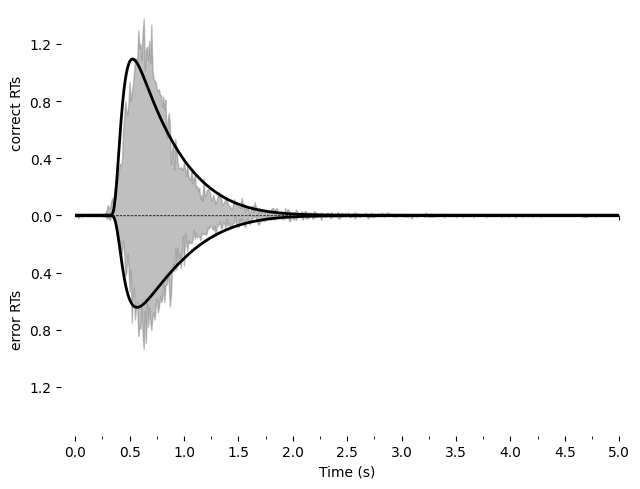

In [25]:
# Visualize model fit diagnostics to evaluate performance
%matplotlib inline
pyddm.plot.plot_fit_diagnostics(model=model_4, sample=data_sample_filtered)
plt.show()